In [58]:
# import labraries
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u
from astropy.constants import m_e, c, hbar, M_sun, G

from scipy.integrate import solve_ivp

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})



Hence, we can approximate for the two different regimes
$$
\epsilon(p) \simeq A_\text{NR}p^{3/5}+ A_\text{R}p^{3/4}, \quad A_\text{NR} = (K_\text{NR})^{-3/5}, A_\text{R} = (K_\text{R})^{-3/4}
$$


The first term dominates for low pressures, when $k_F\ll m_e$ and the second for $k_F\gg m_e$.

Solving the TOV equations for different Equations of state


# TOV Equations

$$
\begin{aligned}
\frac{dp}{dr}&= -\frac{G \epsilon(r)M(r)}{c^2r^2}\bigg(1+ \frac{p(r)}{e(r)}\bigg)\bigg(1+ \frac{4\pi r^3p(r)}{M(r)c^2}\bigg)\bigg(1-\frac{2GM(r)}{c^2r}\bigg)^{-1}\\

\frac{dM}{dr}&= \frac{4 \pi r^2 \epsilon (r)}{c^2}

\end{aligned}
$$


# Electron-degenerated matter (White Dwarf)


Equation of state:

$$
p(\epsilon) = K \epsilon^\gamma
$$
Approximate solutions for two different regimes: (NonRel.  $k_F\ll m_e$, Rel. $k_F\gg m_e$.):
$$
K_\text{NR} = \frac{\hbar^2}{15\pi^2m_e}\bigg(\frac{3 \pi^2 Z}{Am_Nc^2}\bigg)^{5/3} \qquad K_\text{R} = \frac{\hbar \ c}{15\pi^2}\bigg(\frac{3 \pi^2 Z}{Am_Nc^2}\bigg)^{4/3} 
$$
$$
\gamma_\text{NR} = \frac{5}{3} \qquad \gamma_\text{R} = \frac{4}{3} 
$$



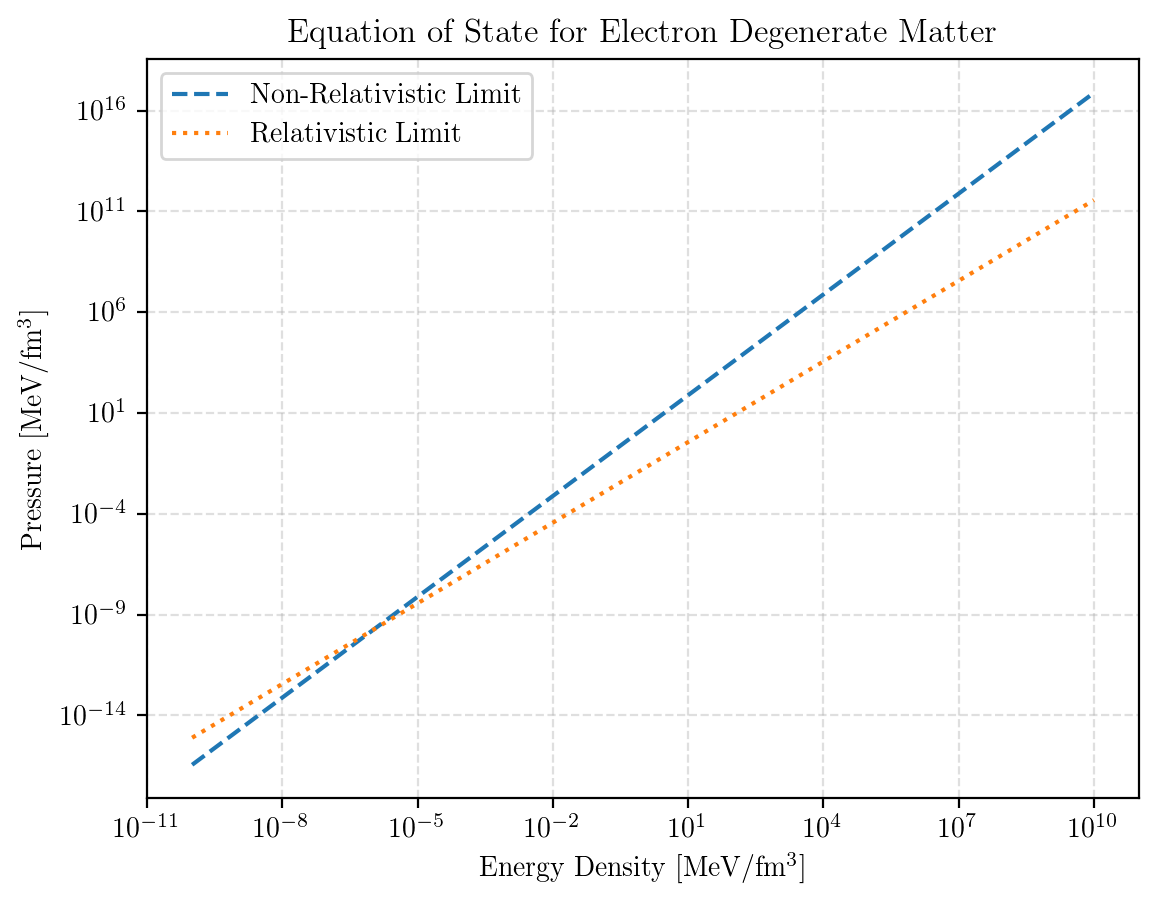

In [59]:
AZ = 1 # A/Z 
K_R  = (hbar * c / 12 / np.pi**2 * ((3 * np.pi**2)/ (931.5 * u.MeV * AZ)) **(4/3)).to('fm / MeV**(1/3)')
K_NR = (hbar ** 2 / 15 / np.pi**2 / m_e * ((3 * np.pi**2)/ (931.5 * u.MeV * AZ)) **(5/3)).to('fm2 / MeV**(2/3)')

def p_R_EOS_electron_matter(e):
    return K_R  * e ** (4/3)

def p_NR_EOS_electron_matter(e):
    return K_NR * e ** (5/3)

e_vals = np.logspace(-10, 10, 1000) * u.MeV / u.fm**3
p_NR_vals = p_NR_EOS_electron_matter(e_vals)
p_R_vals  = p_R_EOS_electron_matter(e_vals)

plt.loglog(e_vals,p_NR_vals, '--', label='Non-Relativistic Limit')
plt.loglog(e_vals, p_R_vals, ':', label='Relativistic Limit')
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.title('Equation of State for Electron Degenerate Matter')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()



We must solve the TOV using dimensionless $\bar p, \bar M$, defined as
$$
\begin{aligned}
p &= \epsilon_0 \bar p\\
\epsilon &= \epsilon_0 \bar \epsilon\\
M &= M_0 \bar M\\
K &= \epsilon_0^{1-\gamma} \bar K\\
\bar p &= \bar K \bar \epsilon^\gamma
\end{aligned}
$$

The TOV becomes

$$
\begin{aligned}
\frac{d\bar p}{dr}&= -\frac{G M_0}{c^2}\left(\frac{\bar p}{\bar K}\right) ^{1/\gamma}\frac{\bar M }{r^2}
\bigg(1+ \bar p^{1-1/\gamma} \bar K^{1/\gamma}\bigg)
\bigg(1+ \frac{4\pi \epsilon_0\bar p}{M_0 \bar M c^2} r^3 \bigg)
\bigg(1-\frac{2G M_0 \bar M}{c^2r}\bigg)^{-1}\\

\frac{d \bar M}{dr}&= \frac{4 \pi\epsilon_0 r^2}{M_0c^2} \left(\frac{\bar p}{\bar K}\right) ^{1/\gamma}  

\end{aligned}
$$


In [60]:
#---- Saturation density and energy density ----

n_0 = 0.16 * u.fm**-3 # saturation density
m_0 = 939 * u.MeV / c**2  # neutron mass
e_0 = n_0 * m_0 * c**2 # saturation energy density


K_R  = (hbar * c / 12 / np.pi**2 * ((3 * np.pi**2)/ (931.5 * u.MeV * AZ)) **(4/3)).to('fm / MeV**(1/3)')
gamma_R = 4/3
K_0_R = e_0**(1-gamma_R)
K_R = K_R/K_0_R

print(f"K_R = {K_R:.3e}")

def p_R_EOS_electron_matter(e):
    return K_R  * e ** (4/3)


K_NR = (hbar ** 2 / 15 / np.pi**2 / m_e * ((3 * np.pi**2)/ (931.5 * u.MeV * AZ)) **(5/3)).to('fm2 / MeV**(2/3)')
gamma_NR = 5/3
K_0_NR = e_0**(1-gamma_NR)
K_NR = K_NR/K_0_NR
def p_NR_EOS_electron_matter(e):
    return K_NR * e ** (5/3)
print(f"K_NR = {K_NR:.3e}")

K_R = 8.918e-02
K_NR = 4.640e+01


In [93]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------
R_0 = (G * M_sun / c**2).to(u.km)  # in km

alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

def R_TOV_electron_matter(r, x):
    p, M = x
    if p < 0:
        # avoid negative pressure during integration
        return [0, 0]

    term1 = R_0.value * (p/K_R)**(1/gamma_R) * M / r**2
    term2 = 1 + p**(1-1/gamma_R) * K_R**(1/gamma_R)
    if M == 0:
        term3 = 1.0
    else:
        term3 = 1.0 + alpha * r**3 * p / M
    term4 = 1 - 2 * R_0.value * M / r

    if term4 <= 0:
        return [0, 0]

    dpdr = - term1 * term2 * term3 / term4
    dMdr = alpha * r**2 * (p/K_R)**(1/gamma_R)

    return [dpdr, dMdr]



# ----------------------------------------------------
# Initial conditions
# ----------------------------------------------------
central_energy = 10.0**(-11)   # in units of e0
central_pressure =  p_R_EOS_electron_matter(central_energy)

r0 = 0.1             
central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
x0 = [central_pressure, central_mass]   # p(r0), M(r0)

# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative

# ----------------------------------------------------
# Solve ODE
# ----------------------------------------------------
sol = solve_ivp(
   R_TOV_electron_matter,
    (r0, 200000),    
    x0,
    events=surface_event, 
    max_step=0.5,
    rtol=1e-1, atol=1e-1 #tolerance of the step size selection
)

# Extract full profiles (for plotting etc.)
radius = sol.t
pressure = sol.y[0]
mass = sol.y[1]

# Surface location from event
R_surface = sol.t_events[0][0] # 0, 0 because only one event
P_surface = sol.y_events[0][0][0] #stores the state vector at the event
M_surface = sol.y_events[0][0][1]

print("Surface radius:", R_surface)
print("Pressure at surface:", P_surface)   # Should be exactly 0
print("Mass at surface:", M_surface)

# If you also want the last raw solver step (not recommended)
final_pressure_raw = sol.y[0, -1]
print("Final raw pressure:", final_pressure_raw)
print("Final pressure:", P_surface * e_0)

# ----------------------------------------------------
# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(radius, pressure*e_0)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV/fm$^3$]")
plt.title("TOV Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
plt.plot(radius, mass)
plt.xlabel("R [km]")
plt.ylabel("M/M$_\odot$")
plt.title("Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()



IndexError: index 0 is out of bounds for axis 0 with size 0

No surface event for central energy = 1e-11
No surface event for central energy = 3.1622776601683794e-11
No surface event for central energy = 1e-10
No surface event for central energy = 3.1622776601683795e-10
No surface event for central energy = 1e-09


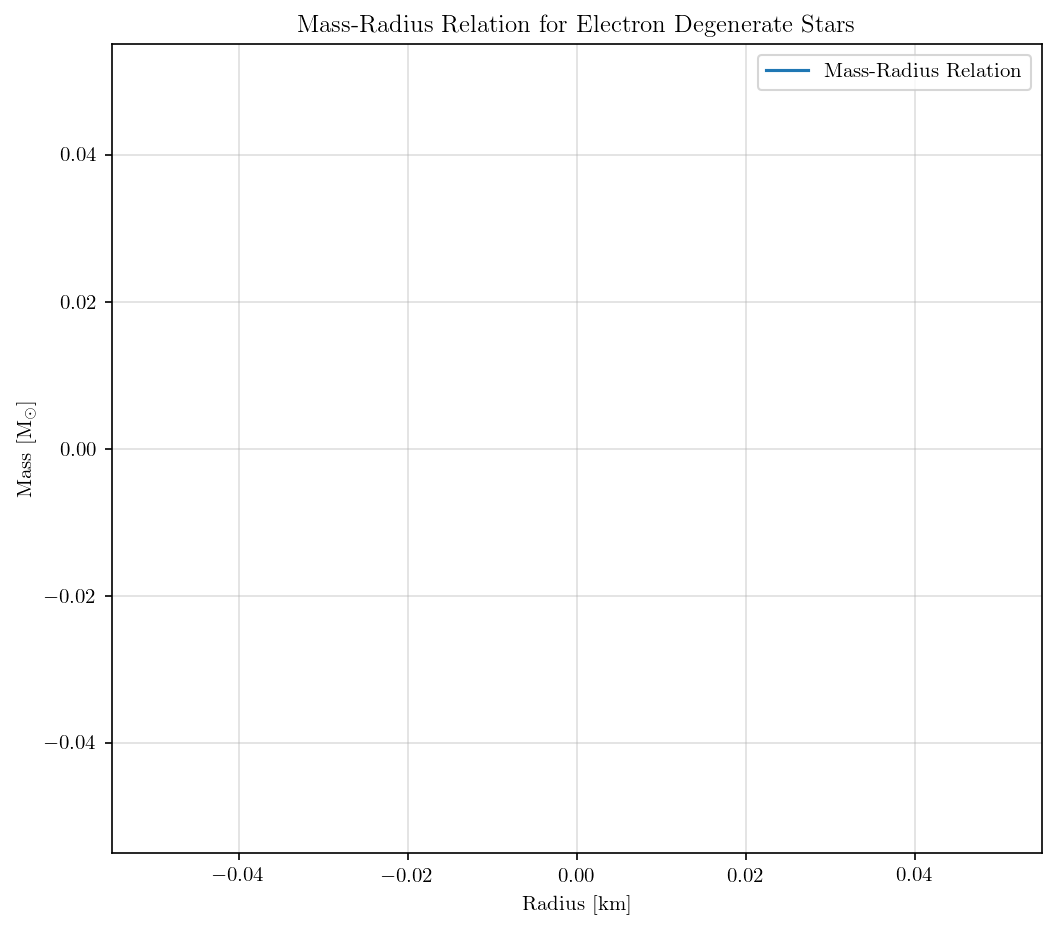

In [88]:
central_energies = np.logspace(-11, -9, 5)
def solve_TOV(central_energy):

    central_pressure =  p_R_EOS_electron_matter(central_energy)

    r0 = 0.1             
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass]   # p(r0), M(r0)

    sol = solve_ivp(
         R_TOV_electron_matter,
        (r0, 20000),     # integrate up to r=1000 (large enough)
        x0,
        events=surface_event, 
        max_step=5.0,
        rtol=1e-1, atol=1e-1 #tolerance of the step size selection
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface* e_0, 'MeV/fm^3')

    return R_surface, M_surface

radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce)
    radii.append(R_star)
    masses.append(M_star)
plt.figure(figsize=(8,7), dpi=150)
plt.plot(radii, masses, label='Mass-Radius Relation')
plt.scatter(radii, masses, s=1)
plt.xlabel('Radius [km]')
plt.ylabel('Mass [M$_\odot$]')
plt.title('Mass-Radius Relation for Electron Degenerate Stars')
plt.grid()
plt.legend()
plt.show()


Surface radius: 1218.504690706549
Pressure at surface: -8.582806648804608e-28
Mass at surface: 163.35436647415597
Final raw pressure: -8.582806648804608e-28
Final pressure: -1.289480870916404e-25 MeV / fm3


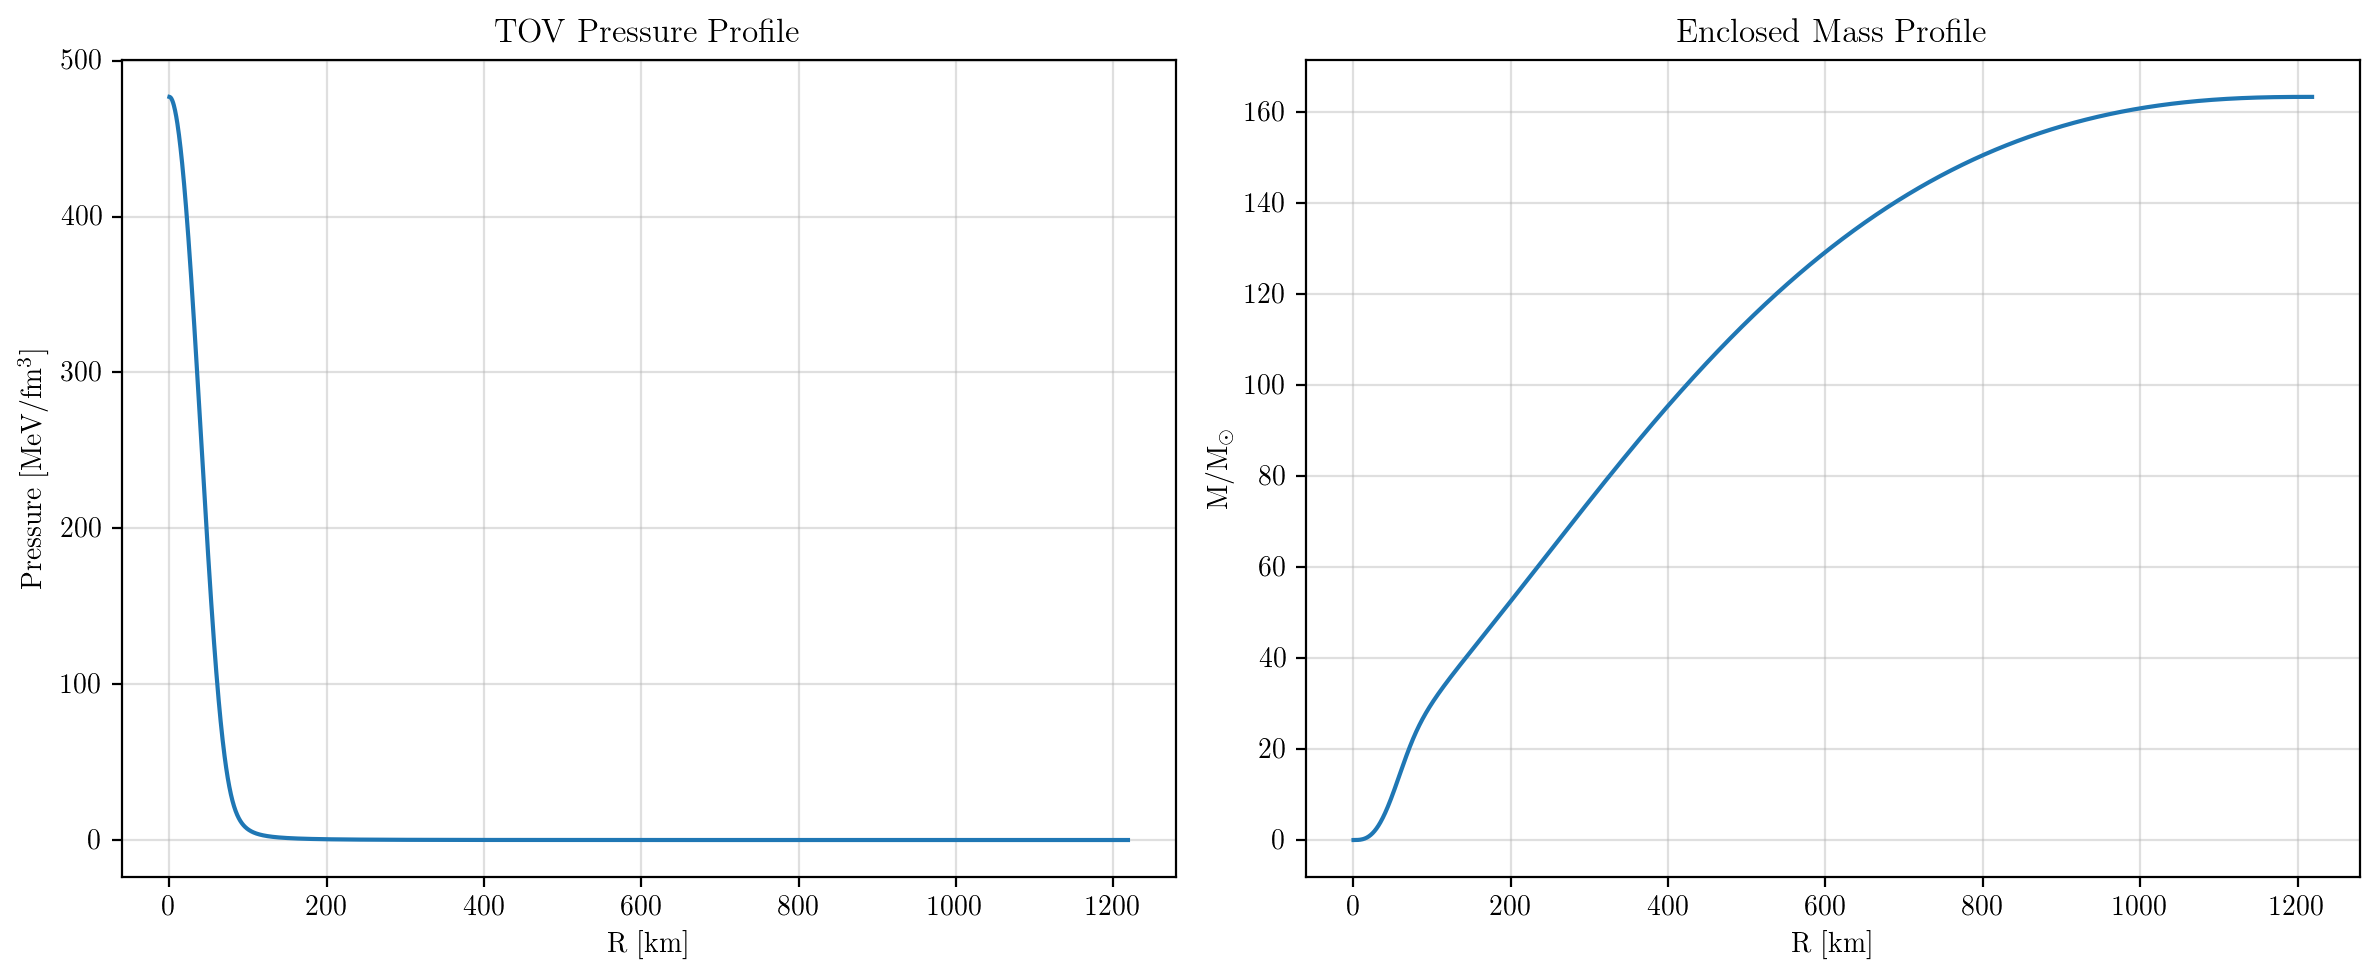

In [63]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------
R_0 = (G * M_sun / c**2).to(u.km)  # in km

alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

def NR_TOV_electron_matter(r, x):
    p, M = x
    if p < 0:
        # avoid negative pressure during integration
        return [0, 0]

    term1 = R_0.value * (p/K_NR)**(1/gamma_NR) * M / r**2
    term2 = 1 + p**(1-1/gamma_NR) * K_R**(1/gamma_NR)
    if M == 0:
        term3 = 1.0
    else:
        term3 = 1.0 + alpha * r**3 * p / M
    term4 = 1 - 2 * R_0.value * M / r

    if term4 <= 0:
        return [0, 0]

    dpdr = - term1 * term2 * term3 / term4
    dMdr = alpha * r**2 * (p/K_NR)**(1/gamma_NR)

    return [dpdr, dMdr]



# ----------------------------------------------------
# Initial conditions
# ----------------------------------------------------
central_energy = 0.2   # in units of e0
central_pressure =  p_NR_EOS_electron_matter(central_energy)

r0 = 0.1             
central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
x0 = [central_pressure, central_mass]   # p(r0), M(r0)

# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative

# ----------------------------------------------------
# Solve ODE
# ----------------------------------------------------
sol = solve_ivp(
    NR_TOV_electron_matter,
    (r0, 10000),     # integrate up to r=20 (large enough)
    x0,
    events=surface_event, 
    max_step=0.5,
    rtol=1e-8, atol=1e-10 #tolerance of the step size selection
)

# Extract full profiles (for plotting etc.)
radius = sol.t
pressure = sol.y[0]
mass = sol.y[1]

# Surface location from event
R_surface = sol.t_events[0][0] # 0, 0 because only one event
P_surface = sol.y_events[0][0][0] #stores the state vector at the event
M_surface = sol.y_events[0][0][1]

print("Surface radius:", R_surface)
print("Pressure at surface:", P_surface)   # Should be exactly 0
print("Mass at surface:", M_surface)

# If you also want the last raw solver step (not recommended)
final_pressure_raw = sol.y[0, -1]
print("Final raw pressure:", final_pressure_raw)
radius = sol.t
pressure = sol.y[0]
mass = sol.y[1]
final_pressure = sol.y[0, -1] * e_0
print("Final pressure:", final_pressure)

# ----------------------------------------------------
# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(radius, pressure*e_0)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV/fm$^3$]")
plt.title("TOV Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
plt.plot(radius, mass)
plt.xlabel("R [km]")
plt.ylabel("M/M$_\odot$")
plt.title("Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()


No surface event for central energy = 0.1
No surface event for central energy = 10.0


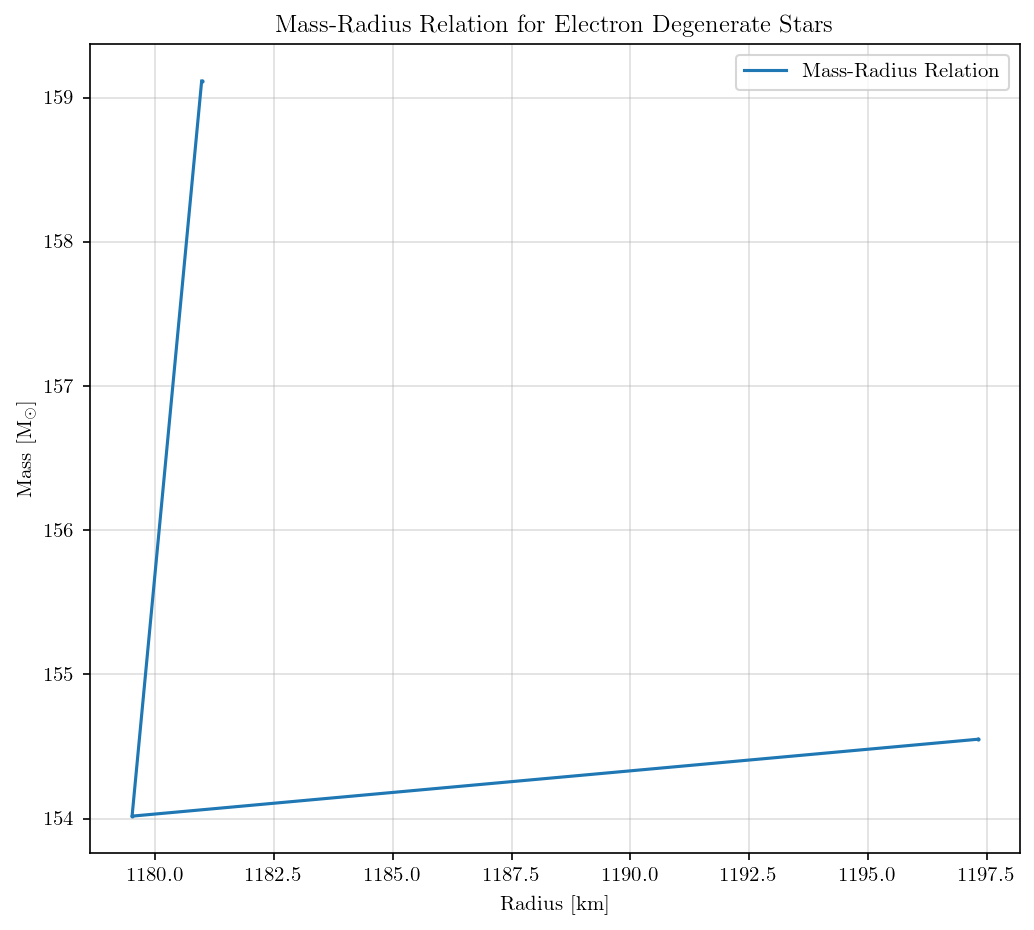

In [76]:

central_energies = np.logspace(-1, 1, 5)
def solve_TOV(central_energy):

    central_pressure =  p_NR_EOS_electron_matter(central_energy)

    r0 = 0.1             
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass]   # p(r0), M(r0)

    sol = solve_ivp(
        NR_TOV_electron_matter,
        (r0, 1200),     # integrate up to r=1000 (large enough)
        x0,
        events=surface_event, 
        max_step=0.5,
        rtol=1e-8, atol=1e-10 #tolerance of the step size selection
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface* e_0, 'MeV/fm^3')

    return R_surface, M_surface

radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce)
    radii.append(R_star)
    masses.append(M_star)
plt.figure(figsize=(8,7), dpi=150)
plt.plot(radii, masses, label='Mass-Radius Relation')
plt.scatter(radii, masses, s=1)
plt.xlabel('Radius [km]')
plt.ylabel('Mass [M$_\odot$]')
plt.title('Mass-Radius Relation for Electron Degenerate Stars')
plt.grid()
plt.legend()
plt.show()

In [84]:
pc=(10**(-19) * 7.463 * 10 ** 39)* u.erg/u.cm**3
pc = pc.to(u.MeV/u.fm**3)/e_0
print(f"pc = {pc:.3e} e0")

e=(pc/K_NR)**(1/gamma_NR)
print(f"e = {e:.3e} e0")

pc = 3.100e-15 e0
e = 1.972e-10 e0


per aquesta equacio de la wd, mai arriba al zero. per tant aquest metode de integracio no es prou bo. o li hauria de ddonar mes marge, o dirli com a event que pari quan el valor de la integral hagi conb=vergit dins d'un marge